# Import Libraries

In [46]:
# LIBRARY
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import random
import tqdm
import sklearn.metrics as metrics

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score, multilabel_confusion_matrix, roc_curve
from sklearn.multioutput import MultiOutputClassifier

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, InputSpec
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *

from scipy.sparse import issparse
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset
from skmultilearn.ext import Keras

# Read Data

In [47]:
data = pd.read_csv('Final_dataset_Diabetes_Complication.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,3,1,1,1,1,1,1,1,3,1,...,1,3,1,2,2,1,2,2,1,2
1,5,3,1,1,2,4,2,1,5,1,...,1,2,2,2,2,2,2,2,1,1
2,4,1,1,1,2,1,2,2,2,2,...,2,3,1,2,2,2,2,2,2,1
3,4,1,1,1,2,4,2,1,1,1,...,2,3,2,2,2,2,1,2,1,2
4,2,1,1,3,1,3,1,1,1,1,...,1,3,1,2,2,2,2,2,2,2


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604078 entries, 0 to 604077
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   X1      604078 non-null  int64
 1   X2      604078 non-null  int64
 2   X3      604078 non-null  int64
 3   X4      604078 non-null  int64
 4   X5      604078 non-null  int64
 5   X6      604078 non-null  int64
 6   X7      604078 non-null  int64
 7   X8      604078 non-null  int64
 8   X9      604078 non-null  int64
 9   X10     604078 non-null  int64
 10  X11     604078 non-null  int64
 11  X12     604078 non-null  int64
 12  X13     604078 non-null  int64
 13  X14     604078 non-null  int64
 14  X15     604078 non-null  int64
 15  X16     604078 non-null  int64
 16  X17     604078 non-null  int64
 17  X18     604078 non-null  int64
 18  X19     604078 non-null  int64
 19  X20     604078 non-null  int64
 20  X21     604078 non-null  int64
 21  X22     604078 non-null  int64
 22  X23     604078 non-n

In [49]:
ordinal_label = ['X1', 'X2', 'X4', 'X6', 'X9', 'X11', 'X12', 'X13', 'X14', 'X19', 'X20', 'X21', 'X23', 'X24', 'X25']

In [50]:
data.eq(0).any()

X1     False
X2     False
X3     False
X4     False
X5     False
X6     False
X7     False
X8     False
X9     False
X10    False
X11    False
X12    False
X13    False
X14    False
X15    False
X16    False
X17    False
X18    False
X19    False
X20    False
X21    False
X22    False
X23    False
X24    False
X25    False
X26    False
Y1     False
Y2     False
Y3     False
Y4     False
Y5     False
Y6     False
Y7     False
dtype: bool

# Data Visualization

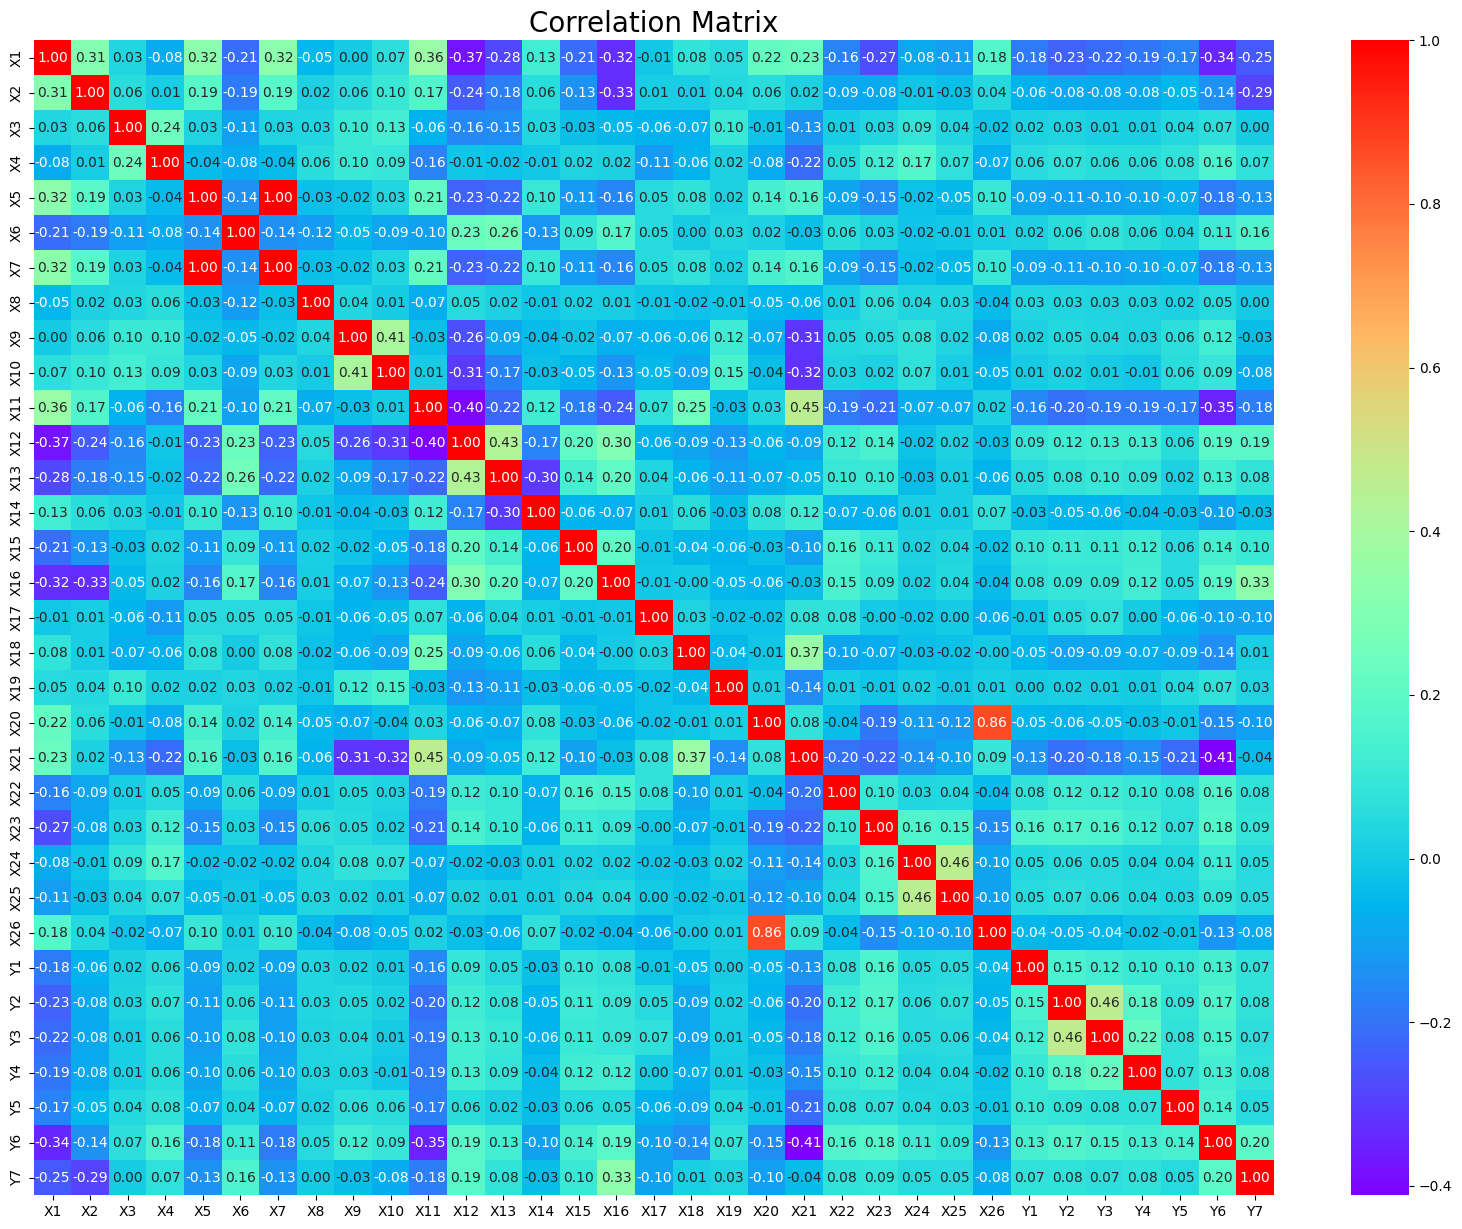

In [51]:
f, ax = plt.subplots(figsize= [20,15])
corr = data.corr()
sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [52]:
data_feature = data.iloc[:, :26]
data_label = data.iloc[:, 26:]
data_label

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,2,2,1,2,2,1,2
1,2,2,2,2,2,1,1
2,2,2,2,2,2,2,1
3,2,2,2,1,2,1,2
4,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
604073,2,2,2,2,2,2,2
604074,2,2,1,2,2,2,1
604075,2,2,2,2,2,2,1
604076,2,2,2,2,1,2,2


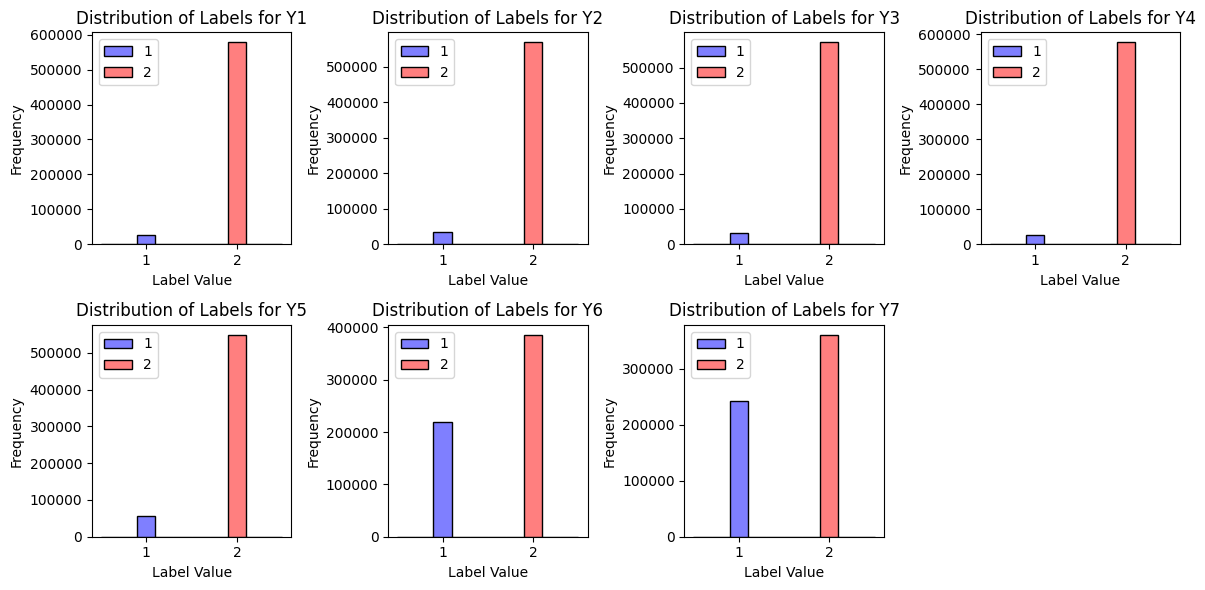

In [53]:
num_rows = 2  # Adjust as needed
num_cols = 4  # Adjust as needed

# Loop through each label column and create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
for i, label in enumerate(data_label.columns):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]

    # Filter values 1 and 2 from the label column
    values_1 = data_label[label][data_label[label] == 1]
    values_2 = data_label[label][data_label[label] == 2]

    # Create a histogram or bar plot on the current subplot
    sns.histplot(values_1, bins=5, color='blue', alpha=0.5, label='1', ax=ax)
    sns.histplot(values_2, bins=5, color='red', alpha=0.5, label='2', ax=ax)

    ax.set_title(f'Distribution of Labels for {label}')
    ax.set_xlabel('Label Value')
    ax.set_ylabel('Frequency')
    ax.legend()

if 7 < num_rows * num_cols:
    for j in range(7, num_rows * num_cols):
        fig.delaxes(axes.ravel()[j])

# Ensure tight layout to avoid overlapping
plt.tight_layout()
plt.show()

In [54]:
dist_list = []
for i, label in enumerate(data_label.columns):
    values_1 = data_label[label][data_label[label] == 1]
    values_2 = data_label[label][data_label[label] == 2]
    dist = 1 - len(values_1) / len(data_label)
    dist_list.append(dist)

In [55]:
len(data_feature)

604078

In [56]:
dist_list

[0.9564211906409437,
 0.9411731597575148,
 0.945454063879168,
 0.9542029340581846,
 0.9079903588609418,
 0.6380285327391495,
 0.5973036594611953]

# Data Preprocessing

In [57]:
x = data.iloc[:, :26].values
y = data.iloc[:, 26:].values-1

In [58]:
scaler = MinMaxScaler()
scaler.fit(x)
X = scaler.transform(x)
X

array([[0.5 , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [1.  , 1.  , 0.  , ..., 0.  , 0.5 , 1.  ],
       [0.75, 0.  , 0.  , ..., 1.  , 1.  , 0.  ],
       ...,
       [0.  , 0.5 , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.5 , 0.  , 1.  , ..., 0.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 1.  ]])

In [59]:
scaler.fit(y)
Y = scaler.transform(y)
Y

array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [60]:
print(x.shape, y.shape)

(604078, 26) (604078, 7)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Modelling

## Dropout Method

In [62]:
import keras.backend as K
from keras import initializers
from keras.layers import Dense, Lambda, Wrapper


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        # this is very weird.. we must call super before we add new losses
        super(ConcreteDropout, self).build()

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                             shape=(1,),
                                             initializer=initializers.RandomUniform(
                                                 self.init_min, self.init_max),
                                             trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * \
            K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)


In [63]:
class VariationalDropout(Layer):
  """A layer that implements variational dropout.

  This layer uses a variational inference approach to learn the dropout probabilities.

  Args:
    input_shape: The shape of the input tensor.
    keep_prob: The initial keep probability.
    dtype: The data type of the dropout mask.

  Attributes:
    mask_saved: The dropout mask.
    """

  def __init__(self, input_shape, keep_prob, dtype=None):
    super(VariationalDropout, self).__init__()

    self.input_shape = input_shape
    self.keep_prob = keep_prob
    self.dtype = tf.float32 if dtype is None else dtype
    self.mask_saved = tf.get_variable(
        "variational_mask", input_shape, trainable=False,
        initializer=tf.ones_initializer())

  def call(self, inputs):
    """Applies variational dropout to the input tensor.

    Args:
      inputs: The input tensor.

    Returns:
      The output tensor with variational dropout applied.
    """

    ret = tf.math.divide(inputs, self.keep_prob) * self.mask_saved
    return ret

  def get_update_mask_op(self):
    """Returns the operation to update the dropout mask."""

    binary_tensor = self._get_binary_mask(self.input_shape, self.dtype)
    update_op = tf.assign(self.mask_saved, binary_tensor)
    return [update_op]

  def _get_binary_mask(self, noise_shape, dtype):
    """Computes the binary dropout mask.

    Args:
      noise_shape: The shape of the dropout mask.
      dtype: The data type of the dropout mask.

    Returns:
      A binary dropout mask.
    """

    random_tensor = self.keep_prob
    random_tensor += tf.random.uniform(
        noise_shape, seed=self.seed, dtype=dtype)
    # 0. if [keep_prob, 1.0) and 1. if [1.0, 1.0 + keep_prob)
    binary_tensor = tf.math.floor(random_tensor)
    return binary_tensor

In [64]:
class BetaDropout(Layer):
    """A layer that implements Beta Dropout.

    Args:
    input_shape: The shape of the input tensor.
    rate: A float between 0 and 1, or a tuple of two floats that specify the alpha and beta hyperparameters of the beta distribution.
    noise_shape: None for pointwise dropout, or shape of the binary dropout mask for spatial dropout.
    dtype: The data type of the dropout mask.

    Attributes:
    mask_saved: The dropout mask.
    """

    def __init__(self, input_shape, rate, noise_shape=None, dtype=None):
        super(BetaDropout, self).__init__()

        self.input_shape = input_shape
        self.rate = rate
        self.noise_shape = noise_shape
        self.dtype = tf.float32 if dtype is None else dtype
        self.mask_saved = tf.get_variable(
            "beta_dropout_mask", input_shape, trainable=False,
            initializer=tf.ones_initializer())

    def call(self, inputs):
        """Applies Beta Dropout to the input tensor.

        Args:
            inputs: The input tensor.

        Returns:
            The output tensor with Beta Dropout applied.
        """

        ret = tf.math.divide(inputs, self.rate) * self.mask_saved
        return ret

    def get_update_mask_op(self):
        """Returns the operation to update the dropout mask."""

        binary_tensor = self._get_binary_mask(self.input_shape, self.dtype)
        update_op = tf.assign(self.mask_saved, binary_tensor)
        return [update_op]

    def _get_binary_mask(self, noise_shape, dtype):
        """Computes the binary dropout mask.

        Args:
            noise_shape: The shape of the dropout mask.
            dtype: The data type of the dropout mask.

        Returns:
            A binary dropout mask.
        """

        beta_distribution = tf.distributions.Beta(self.rate, self.rate)
        random_tensor = beta_distribution.sample(noise_shape)
        binary_tensor = tf.math.floor(random_tensor)
        return binary_tensor

In [65]:
class ContinuousDropout(Layer):
    pass

In [66]:
class InformationDropout(Layer):
    pass

In [67]:
class GaussianSoftDropout(Layer):
    pass

In [68]:
class LaplaceSoftDropout(Layer):
    pass

In [69]:
class WeightedDropout(Layer):
    def __init__(self, rate=0.5):
        super(WeightedDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training is None:
            training = tf.keras.backend.learning_phase()

        def dropout():
            return tf.keras.backend.dropout(inputs, level=self.rate)

        def weighted_dropout():
            mask = tf.keras.backend.random_uniform(shape=tf.shape(inputs), minval=0, maxval=1) > self.rate
            return inputs * tf.cast(mask, dtype=inputs.dtype)

        return tf.keras.backend.in_train_phase(dropout, weighted_dropout, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate
        })
        return config


In [70]:
class WeightedGaussianDropout(Layer):
    def __init__(self, mean, stddev, **kwargs):
        super(WeightedGaussianDropout, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training is None:
            training = tf.keras.backend.learning_phase()

        def dropout():
            shape = tf.shape(inputs)
            gaussian_dropout = tf.random.normal(shape, mean=self.mean, stddev=self.stddev)
            return inputs * gaussian_dropout

        return tf.keras.backend.in_train_phase(dropout, inputs, training=training)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "mean": self.mean,
            "stddev": self.stddev,
        })
        return config


In [71]:
class AdvancedDropout(tf.keras.layers.Layer):
    def __init__(self, num, init_mu=0, init_sigma=1.2, reduction=16, **kwargs):
        super(AdvancedDropout, self).__init__(**kwargs)

        self.num = num
        self.init_mu = init_mu
        self.init_sigma = init_sigma
        self.reduction = reduction

        # Initialize parameters
        self.weight_h = tf.Variable(tf.random.normal([num // reduction, num]), name='weight_h')
        self.bias_h = tf.Variable(tf.random.normal([1]), name='bias_h')

        self.weight_mu = tf.Variable(tf.random.normal([1, num // reduction]), name='weight_mu')
        self.bias_mu = tf.Variable(tf.ones([1]), name='bias_mu')

        self.weight_sigma = tf.Variable(tf.random.normal([1, num // reduction]), name='weight_sigma')
        self.bias_sigma = tf.Variable(tf.ones([1]), name='bias_sigma')

    def call(self, inputs):
        if getattr(self, 'is_training', True):
            # Training mode
            # Parameterized prior
            h = tf.matmul(inputs, self.weight_h) + self.bias_h

            mu = tf.reduce_mean(tf.matmul(h, self.weight_mu) + self.bias_mu)
            sigma = tf.reduce_mean(tf.nn.softplus(tf.matmul(h, self.weight_sigma) + self.bias_sigma))

            # Mask
            epsilon = mu + sigma * tf.random.normal(tf.shape(inputs))
            mask = tf.math.sigmoid(epsilon)

            # Output
            out = inputs * mask / tf.math.sigmoid(mu / tf.sqrt(1. + 3.14 / 8. * tf.square(sigma)))
        else:
            # Inference mode
            out = inputs

        return out

## DNN Model

In [76]:
def ProposedModel(n_inputs, n_outputs, drop_layer='gauss'):
    inputLayer = Input(shape=(n_inputs,))
    num_split = 5
    x = Dense(num_split, activation='softmax')(inputLayer)
    split = tf.split(x, num_or_size_splits=num_split, axis=-1)
    dropout_rate = 0.5
    do_layer = drop_layer
    if do_layer == 'gauss':
        dropout_output = [WeightedGaussianDropout(mean=0.3, stddev=0.8)(channel) for channel in split]
    elif do_layer == 'bernoulli':
        dropout_output = [WeightedDropout(dropout_rate)(channel) for channel in split]
    elif do_layer == 'advanced':
        dropout_output = [AdvancedDropout(1)(channel) for channel in split]
    elif do_layer == 'concrete':
        dropout_output = [ConcreteDropout(Dense(1))(channel) for channel in split]
    elif do_layer == 'variational':
        dropout_output = [VariationalDropout()(channel) for channel in split]
    elif do_layer == 'beta':
        dropout_output = [BetaDropout()(channel) for channel in split]
    elif do_layer == 'continuous':
        dropout_output = [ContinuousDropout()(channel) for channel in split]
    elif do_layer == 'information':
        dropout_output = [InformationDropout()(channel) for channel in split]
    elif do_layer == 'gaussoft':
        dropout_output = [GaussianSoftDropout()(channel) for channel in split]
    elif do_layer == 'laplace':
        dropout_output = [LaplaceSoftDropout()(channel) for channel in split]
    
    concat = tf.concat(dropout_output, axis=-1)
    x = Dense(32, activation='relu')(concat)
    x = Dense(64, activation='relu')(x)
    out = Dense(n_outputs, activation='sigmoid')(x)
    model = Model(inputs=inputLayer, outputs=out)
    lossWeights = dist_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'], loss_weights=lossWeights)

    return model

In [77]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

model = ProposedModel(26, 7, 'gauss')

Default GPU Device: /device:GPU:0


# Algorithm Adaptation

In [78]:
def callback():
    checkpoint_path = "checkpoint/ProposedModel/ck1.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=0, min_lr=1e-10)

    cp_callback = [ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1), EarlyStopping(patience=2, monitor='accuracy')]
    return cp_callback

In [79]:
def train(model, X_train, y_train, epoch, save=None):
    cp_callback = callback()
    start = time.time()
    model.fit(X_train, y_train, verbose=1, epochs=epoch, callbacks=cp_callback, batch_size=32)
    training_time = time.time() - start
    print(training_time)
    if save is not None:
        save_path = 'SavedModel/ProposedModel/'+save
        model.save(save_path)

In [80]:
train(model, X_train, y_train, 10, 'pm1.h5')

Epoch 1/10
15102/15102 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.5815
Epoch 1: saving model to checkpoint/ProposedModel\ck1.ckpt
15102/15102 [==============================] - 78s 5ms/step - loss: 0.4136 - accuracy: 0.5815
Epoch 2/10
15100/15102 [============================>.] - ETA: 0s - loss: 0.3307 - accuracy: 0.5882
Epoch 2: saving model to checkpoint/ProposedModel\ck1.ckpt
15102/15102 [==============================] - 71s 5ms/step - loss: 0.3307 - accuracy: 0.5882
Epoch 3/10
15093/15102 [============================>.] - ETA: 0s - loss: 0.3225 - accuracy: 0.6177
Epoch 3: saving model to checkpoint/ProposedModel\ck1.ckpt
15102/15102 [==============================] - 73s 5ms/step - loss: 0.3225 - accuracy: 0.6177
Epoch 4/10
15096/15102 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.5396
Epoch 4: saving model to checkpoint/ProposedModel\ck1.ckpt
15102/15102 [==============================] - 74s 5ms/step - loss: 0.3155 - accur

In [81]:
y_pred = model.predict(X_test)

yprob = y_pred
y_pred = y_pred.round()


3776/3776 [==============================] - 6s 1ms/step


## Evaluation

In [82]:
for i in range(y_pred.shape[1]):
    fpr, tpr, threshold = roc_curve(y_test[:, i], yprob[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    print(roc_auc)

0.7514915535655711
0.8042995229234636
0.8009592996411299
0.7877618337682151
0.7068840632181712
0.782351452028237
0.6745757925288348


In [83]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
hamming_loss_score = hamming_loss(y_test, y_pred)
jaccard = jaccard_score(y_test, y_pred, average='micro')
auc_roc = roc_auc_score(y_test, y_pred)


In [84]:
print('Accuracy: %.6f' % (accuracy))
print('Precision: %.6f' % (precision))
print('Recall: %.6f' % (recall))
print('F1 Score: %.6f'% (f1))
print('Hamming Loss: %.6f'% (hamming_loss_score))
print('Jaccard Score: %.6f'% (jaccard))
print('AUC-ROC: %.6f'% (auc_roc))


Accuracy: 0.410947
Precision: 0.879696
Recall: 0.976995
F1 Score: 0.925796
Hamming Loss: 0.132845
Jaccard Score: 0.861844
AUC-ROC: 0.534992


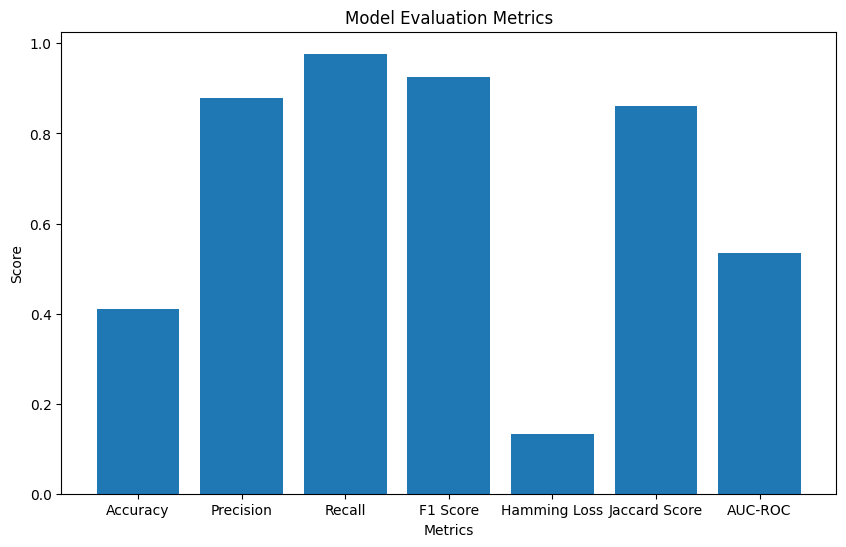

In [85]:
eval_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score',
           'Hamming Loss', 'Jaccard Score', 'AUC-ROC']
eval_values = [accuracy, precision, recall, f1,
          hamming_loss_score, jaccard, auc_roc]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(eval_metrics, eval_values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()


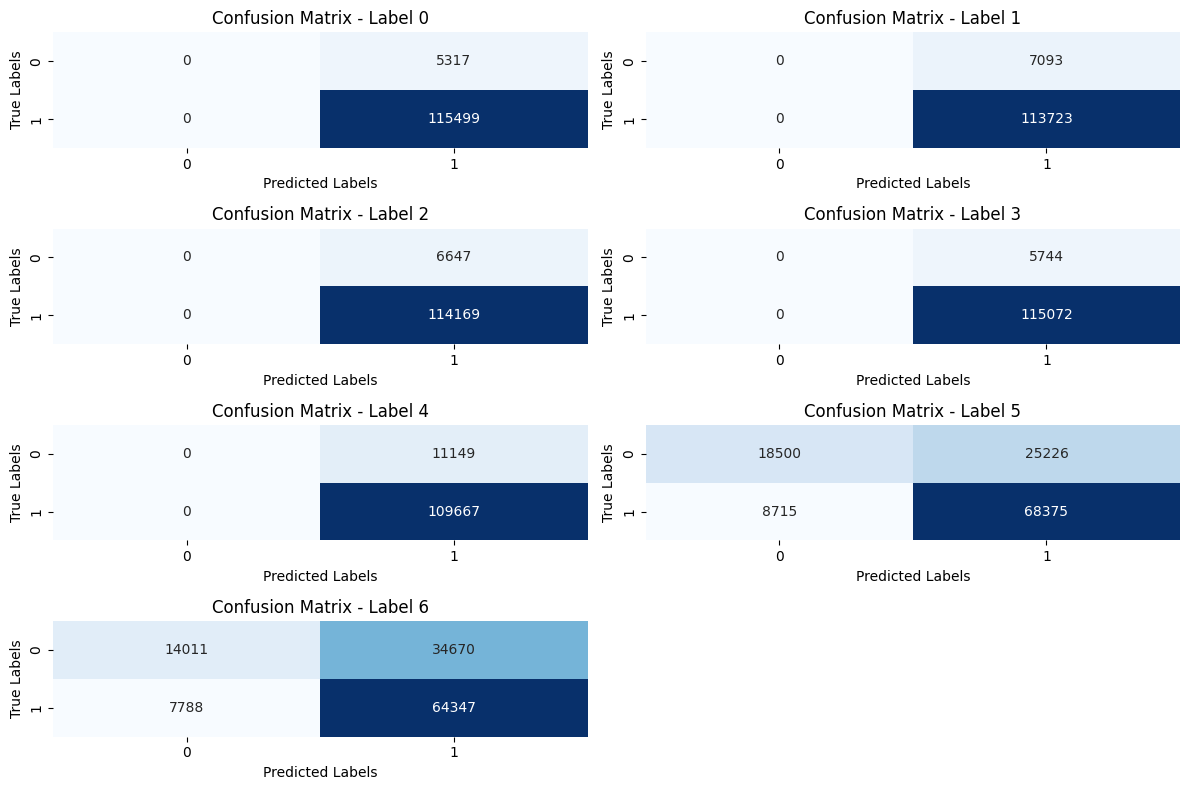

In [86]:
cm = multilabel_confusion_matrix(y_test, y_pred)

# Determine the grid dimensions for subplots
num_labels = cm.shape[0]
cols = min(num_labels, 2)
rows = (num_labels + cols - 1) // cols

# Plot confusion matrix
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for i, (matrix, ax) in enumerate(zip(cm, axes.ravel())):
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - Label {i}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Remove unused subplots if necessary
if num_labels < rows * cols:
    for j in range(num_labels, rows * cols):
        fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()


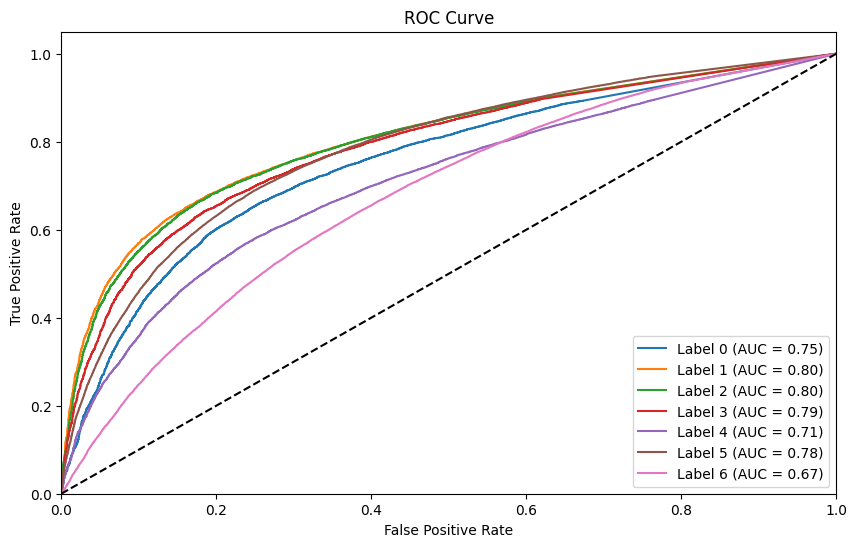

In [87]:
plt.figure(figsize=(10, 6))
roc_auc_per_label = dict()
#predictions=preds
for i in range(y.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], yprob[:, i])
    roc_auc_per_label[i] = roc_auc_score(y_test[:, i], yprob[:, i])
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' %
             (i, roc_auc_per_label[i]))
# Plot ROC curve for each label
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Problem Transformation

In [81]:
keras_model = ProposedModel(26, 7, 'gauss')

In [88]:
load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')

## Binary Relevance

In [89]:
import copy
import numpy as np

class BinaryRelevance:
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        self.label_count = y.shape[1]
        self.classifiers = []
        for i in range(self.label_count):
            print("Label:", i)
            classifier = copy.deepcopy(self.classifier)
            y_subset = y[:, i]
            classifier.fit(X, y_subset)
            self.classifiers.append(classifier)
        return self

    def predict(self, X_pre):
        result = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(self.label_count):
            result[:, i] = self.classifiers[i].predict(X_pre)
        return result


In [91]:
cp_callback = callback()
KERAS_PARAMS = dict(epochs=10, batch_size=64, verbose=1, callbacks=cp_callback)
br = BinaryRelevance(classifier=Keras(ProposedModel, False, KERAS_PARAMS))
br.fit(X_train, y_train)


Epoch 1/10
7546/7551 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9554
Epoch 1: saving model to checkpoint/ProposedModel\ck1.ckpt
7551/7551 [==============================] - 52s 7ms/step - loss: 0.0490 - accuracy: 0.9554
Epoch 2/10
7549/7551 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9565
Epoch 2: saving model to checkpoint/ProposedModel\ck1.ckpt
7551/7551 [==============================] - 51s 7ms/step - loss: 0.0421 - accuracy: 0.9565
Epoch 3/10
7551/7551 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9565
Epoch 3: saving model to checkpoint/ProposedModel\ck1.ckpt
7551/7551 [==============================] - 52s 7ms/step - loss: 0.0410 - accuracy: 0.9565
Epoch 4/10
7548/7551 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9565
Epoch 4: saving model to checkpoint/ProposedModel\ck1.ckpt
7551/7551 [==============================] - 52s 7ms/step - loss: 0.0405 - accuracy: 0.9565
Epoc

In [92]:
br_pred = br.predict(X_test)

3776/3776 [==============================] - 8s 2ms/step


ValueError: could not broadcast input array from shape (120816,1) into shape (120816,)

## Classifier Chain

In [85]:
import copy
import numpy as np

class ClassifierChain:
   
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y, order=None):
        """Fit classifier with training data

        Parameters
        ----------
        order: list
               The order of the labels to join training
        """
        self.m = X.shape[0]
        self.label_count = y.shape[1]
        if order is None:
            self.order = list(range(y.shape[1]))
        elif sorted(order) != list(range(y.shape[1])):
            raise ValueError('invalid order of labels')
        else:
            self.order = order
        self.classifiers = []
        X_extended = copy.deepcopy(X)
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_subset = y[:, self.order[i]]
            classifier.fit(X_extended, y_subset)
            self.classifiers.append(classifier)
            X_extended = np.hstack([X_extended, np.vstack(y_subset)])
        return self

    def predict(self, X_pre):
        res = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(self.label_count):
            y_subset = self.classifiers[i].predict(X_pre)
            X_pre = np.hstack([X_pre, np.vstack(y_subset)])
            res[:, self.order[i]] = y_subset
        return res


In [86]:
cp_callback = callback()
KERAS_PARAMS = dict(epochs=10, batch_size=64, verbose=1, callbacks=cp_callback)
cc = ClassifierChain(classifier=Keras(model, False, KERAS_PARAMS))
cc.fit(X_train, y_train)


INFO:tensorflow:Assets written to: ram://463983db-b1fd-400f-80b9-499a812d99e6/assets


FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://4b01e432-92a4-414a-be9b-b8db761fe8d7/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

## Label Powerset

In [ ]:
cp_callback = callback()
KERAS_PARAMS = dict(epochs=10, batch_size=64, verbose=1, callbacks=cp_callback)
lp = LabelPowerset(classifier=Keras(model, False, KERAS_PARAMS))
lp.fit(X_train, y_train)


## Calibrated Label Ranking

In [ ]:
class CalibratedLabelRanking:
    """Calibratedn Label Ranking
    Reference Paper:
        Min-Ling Zhang and Zhi-Hua Zhou. A Review on Multi-Label Learning Algorithms
        Johannes Fürnkranz. Multilabel classification via calibrated label ranking
    """
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        self.virtualLabel = y.shape[1]
        self.label_count = y.shape[1]
        self.m = X.shape[0]
        self.X = X
        self.y = y
        self.realLabelClassifiers = []
        self.virtualLabelClassifiers = []
        self.trainRealLabelClassifiers()
        self.trainVirtualLabelClassifiers()
        return self

    def trainRealLabelClassifiers(self):
        for i in range(self.label_count):
            for j in range(i+1, self.label_count):
                X_subset = []
                y_subset = []
                classifier = copy.deepcopy(self.classifier)
                for k in range(self.m):
                    if self.y[k, i] == self.y[k, j]:
                        continue
                    elif self.y[k, i] == 1:
                        X_subset.append(self.X[k, :])
                        y_subset.append(i)
                    else:
                        X_subset.append(self.X[k, :])
                        y_subset.append(j)
                try:
                    classifier.fit(np.vstack(X_subset), np.array(y_subset))
                except ValueError:
                    if y_subset[0] == i:
                        classifier = i
                    else:
                        classifier = j
                self.realLabelClassifiers.append(classifier)

    def trainVirtualLabelClassifiers(self):
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_temp= self.y[:, i]
            y_subset = []
            for j in range(self.m):
                y_subset.append(i if y_temp[j] == 1 else self.virtualLabel)
            classifier.fit(self.X, y_subset)
            self.virtualLabelClassifiers.append(classifier)

    def predict(self, X_pre):
        result = np.zeros((X_pre.shape[0], self.label_count))
        threshold = self.voteForVirtualLabel(X_pre)
        votes = self.voteForRealLabel(X_pre)
        for i in range(X_pre.shape[0]):
            result[i, votes[i,:] > threshold[i]] = 1
        return result

    def voteForVirtualLabel(self, X_pre):
        votes = np.zeros(X_pre.shape[0])
        for i in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] == self.virtualLabel:
                    votes[j] += 1
        return votes

    def voteForRealLabel(self, X_pre):
        votes = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(len(self.realLabelClassifiers)):
            if isinstance(self.realLabelClassifiers[i], int):
                predict = np.array([self.realLabelClassifiers[i]] * X_pre.shape[0])
            else:
                predict = self.realLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                votes[j, predict[j]] += 1
        for j in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[j].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] < self.virtualLabel:
                    votes[j, predict[j]] += 1
        return votes
            

In [84]:
cp_callback = callback()
KERAS_PARAMS = dict(epochs=10, batch_size=64, verbose=1, callbacks=cp_callback)
clr = CalibratedLabelRanking(classifier=Keras(model, False, KERAS_PARAMS))
clr.fit(X_train, y_train)

NameError: name 'CalibratedLabelRanking' is not defined